In [109]:
import pandas as pd

Load data which is clean, preprocessed and includes feature engineered features

In [135]:
df_train = pd.read_csv('data/project_mens_train_file_augmented.csv')

In [122]:
import pandas as pd
from sklearn.linear_model import LogisticRegression 

In [123]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Model Preparation
This includes the selection of all relevant features and splitting the dataset into train and validation set

In [124]:
# This list makes it easy to select and deselect features when training the model
feature_set = [
    'rally',
    'serve',
    'speed',
    'net_clearance',
    'distance_from_sideline',
    'depth',
    'outside_sideline',
    'outside_baseline',
    'player_distance_travelled',
    'player_impact_depth',
    'player_impact_distance_from_center',
    'player_depth',
    'player_distance_from_center',
    'previous_speed',
    'previous_net_clearance',
    'previous_distance_from_sideline',
    'previous_depth',
    'opponent_depth',
    'opponent_distance_from_center',
    'same_side',
    'previous_time_to_net',
    'server_is_impact_player',
#     'x_coordinates_bounce',
#     'y_coordinates_bounce',
#     'x_coordinates_previous_bounce',
#     'y_coordinates_previous_bounce',
    'speed_difference',
    'bounce_impact_agg',
    'previous_bounce_agg',
    'player_last_shot_agg',
    'player_second_last_shot_agg',
    'opponent_second_last_shot_agg',
    
    # dummy features
    'hitpoint_B', 
    'hitpoint_F', 
    'hitpoint_U', 
    'hitpoint_V',
    'previous_hitpoint_B', 
    'previous_hitpoint_F', 
    'previous_hitpoint_U',
    'previous_hitpoint_V'
]

Splitting features into train and validation set

In [125]:
from sklearn.model_selection import train_test_split

In [138]:
# X_train, X_val, y_train, y_val = train_test_split(df_train[feature_set], df_train['outcome'], test_size=0.2, random_state=42)

In [161]:
X_train = df_train[feature_set]
y_train = df_train['outcome']

# Model Development

In [162]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [163]:
def get_model_performance(model, df_test):
    X_test = df_test[feature_set]
    y_actual = df_test['outcome']
    
    y_preds = model.predict(X_test)
    
    # Get confusion matrix
    labels = list(y_actual.unique())
    array = confusion_matrix(y_actual, y_preds, labels=labels)
    
    df_cm = pd.DataFrame(array, range(3), range(3))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, ax = ax, fmt='g') # font size

    # # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()

    print('Accuracy score: {}'.format(accuracy_score(y_actual, y_preds)))
    print('Precision score: {}'.format(precision_score(y_actual, y_preds, average='macro')))
    print('Recall score: {}'.format(recall_score(y_actual, y_preds, average='macro')))
    print('F1 score: {}'.format(f1_score(y_actual, y_preds, average='macro')))

### Logistic Regression

In [201]:
log_model = LogisticRegression(random_state=0, max_iter=100000).fit(X_train, y_train)

### Random Forrest

In [188]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [189]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [100, 200, 300]
}

search = GridSearchCV(rf_model, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                     

In [190]:
search.best_params_

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 200}

In [191]:
rf_model = search.best_estimator_.fit(X_train, y_train)

### XGBoost

In [192]:
from sklearn.ensemble import GradientBoostingClassifier

In [193]:
xgb_model = GradientBoostingClassifier(random_state=0)
xgb_model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [203]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [8, 10, 15],
    'learning_rate': [0.15, 0.2, 0.25],
    'n_estimators': [3, 7, 10, 15]
}

search = GridSearchCV(xgb_model, param_grid, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.15,
                                                  loss='deviance', max_depth=6,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=10,
                                                  n_iter_no_change=None,
         

In [204]:
search.best_params_

{'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 15}

In [206]:
search.best_params_

{'learning_rate': 0.25, 'max_depth': 8, 'n_estimators': 15}

In [207]:
xgb_model = search.best_estimator_.fit(X_train, y_train)

In [209]:
xgb_model

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.25, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=15,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Logistic Regression

# Performance evaluation

In [218]:
df_test = pd.read_csv('data/project_mens_test_file_augmented.csv')

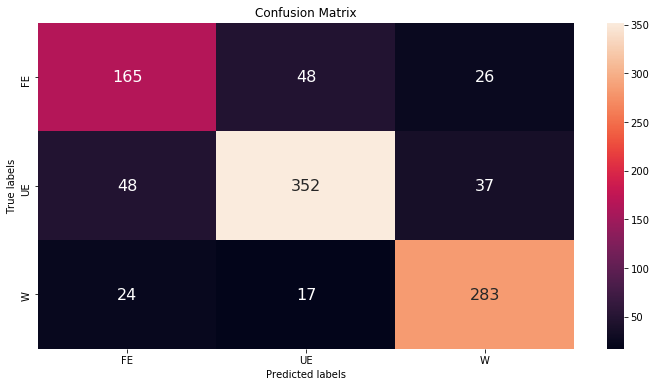

Accuracy score: 0.8
Precision score: 0.7860821023432955
Recall score: 0.7897751166692651
F1 score: 0.7874698007414368


In [219]:
get_model_performance(log_model, df_test)

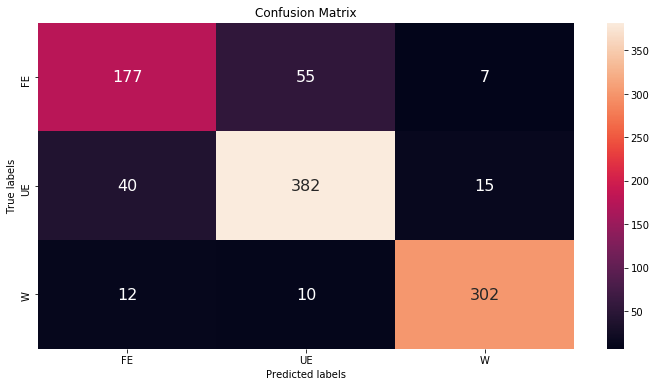

Accuracy score: 0.861
Precision score: 0.8532035531260512
Recall score: 0.848942138640294
F1 score: 0.8509208051691712


In [220]:
get_model_performance(rf_model, df_test)

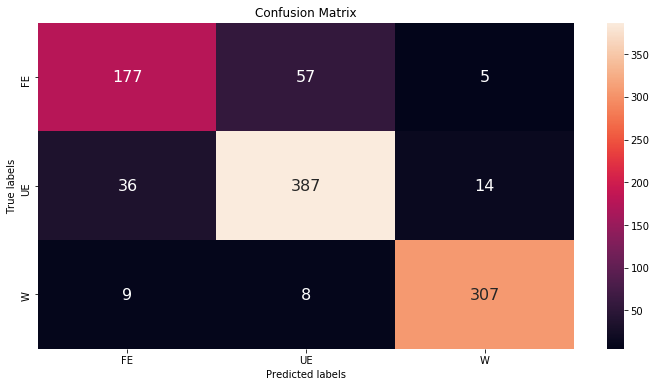

Accuracy score: 0.871
Precision score: 0.865069926324609
Recall score: 0.8579000540945229
F1 score: 0.8610508109980329


In [221]:
get_model_performance(xgb_model, df_test)